# Explicando o projeto

## Introdução

<b>Projeto Semantix EBAC 2024</b>

O projeto nasceu da intenção de ajudar os alunos da EBAC a procurarem ideias de projeto próximas a realidade do mercado na intenção de resolver um problema real utilizando Machine Learning.

## Justificativa

O projeto usa uma base de dados de imóveis com o objetivo de tentar prever o preço do imóvel no mercado. A ideia é ajudar corretoras de imóveis ou constutoras na fase de precificação, achando o melhor preço para construtora e cliente.

A base foi extraída do Kaggle e é usada para competições de Machine Learning na plataforma.

Base de dados: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# Conhecendo o dataframe

## Importando bibliotecas

In [345]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as randint
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             mean_absolute_percentage_error, make_scorer)

from category_encoders import TargetEncoder

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter('ignore')

## Chamando dataframes: train e test

In [346]:
df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv', sep=',')

train = df_train.copy()
test = df_test.copy()

train.drop(columns=['Id'], axis=1, inplace=True)
test.drop(columns=['Id'], axis=1, inplace=True)
row,col = train.shape
print(f"Row: {row} \nCol: {col}")
train.head()

Row: 1460 
Col: 80


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [347]:
# Separando colunas quantitativas e qualitativas
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

## Verificando cols com NANs

In [348]:
# Criando uma lista com as features com mais nulls
percentage = (train.isna().sum() / len(train))
df_pct = percentage.reset_index().rename(columns={'index':'Features', 0: 'pct_nulls'}).sort_values(by='pct_nulls', ascending=False)

## Colunas com mais de 50% de valores nulos
cols_with_more_50 = df_pct[df_pct['pct_nulls']>0.5].reset_index(drop=True)
cols_with_more_50

,Features,pct_nulls
0,PoolQC,0.995205
1,MiscFeature,0.963014
2,Alley,0.937671
3,Fence,0.807534
4,MasVnrType,0.597260


In [349]:
# Saleprice e Id foram removidas das variáveis.
print(len(quantitative))
print(len(qualitative))

36
43


## Distribuição da feature target SalePrice

<Axes: xlabel='SalePrice', ylabel='Count'>

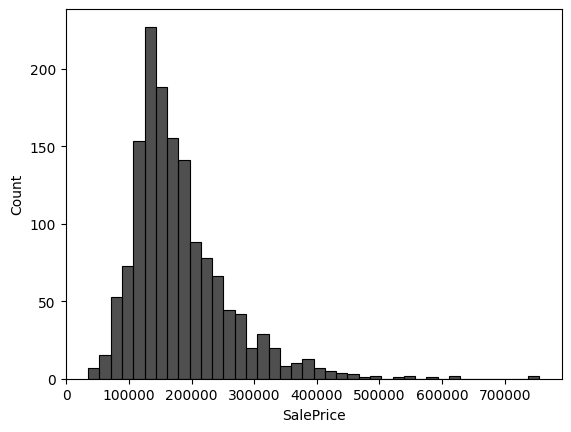

In [350]:
sns.histplot(train, x='SalePrice', bins=40, color='#141414')

## Verificando distribuição de variáveis numéricas

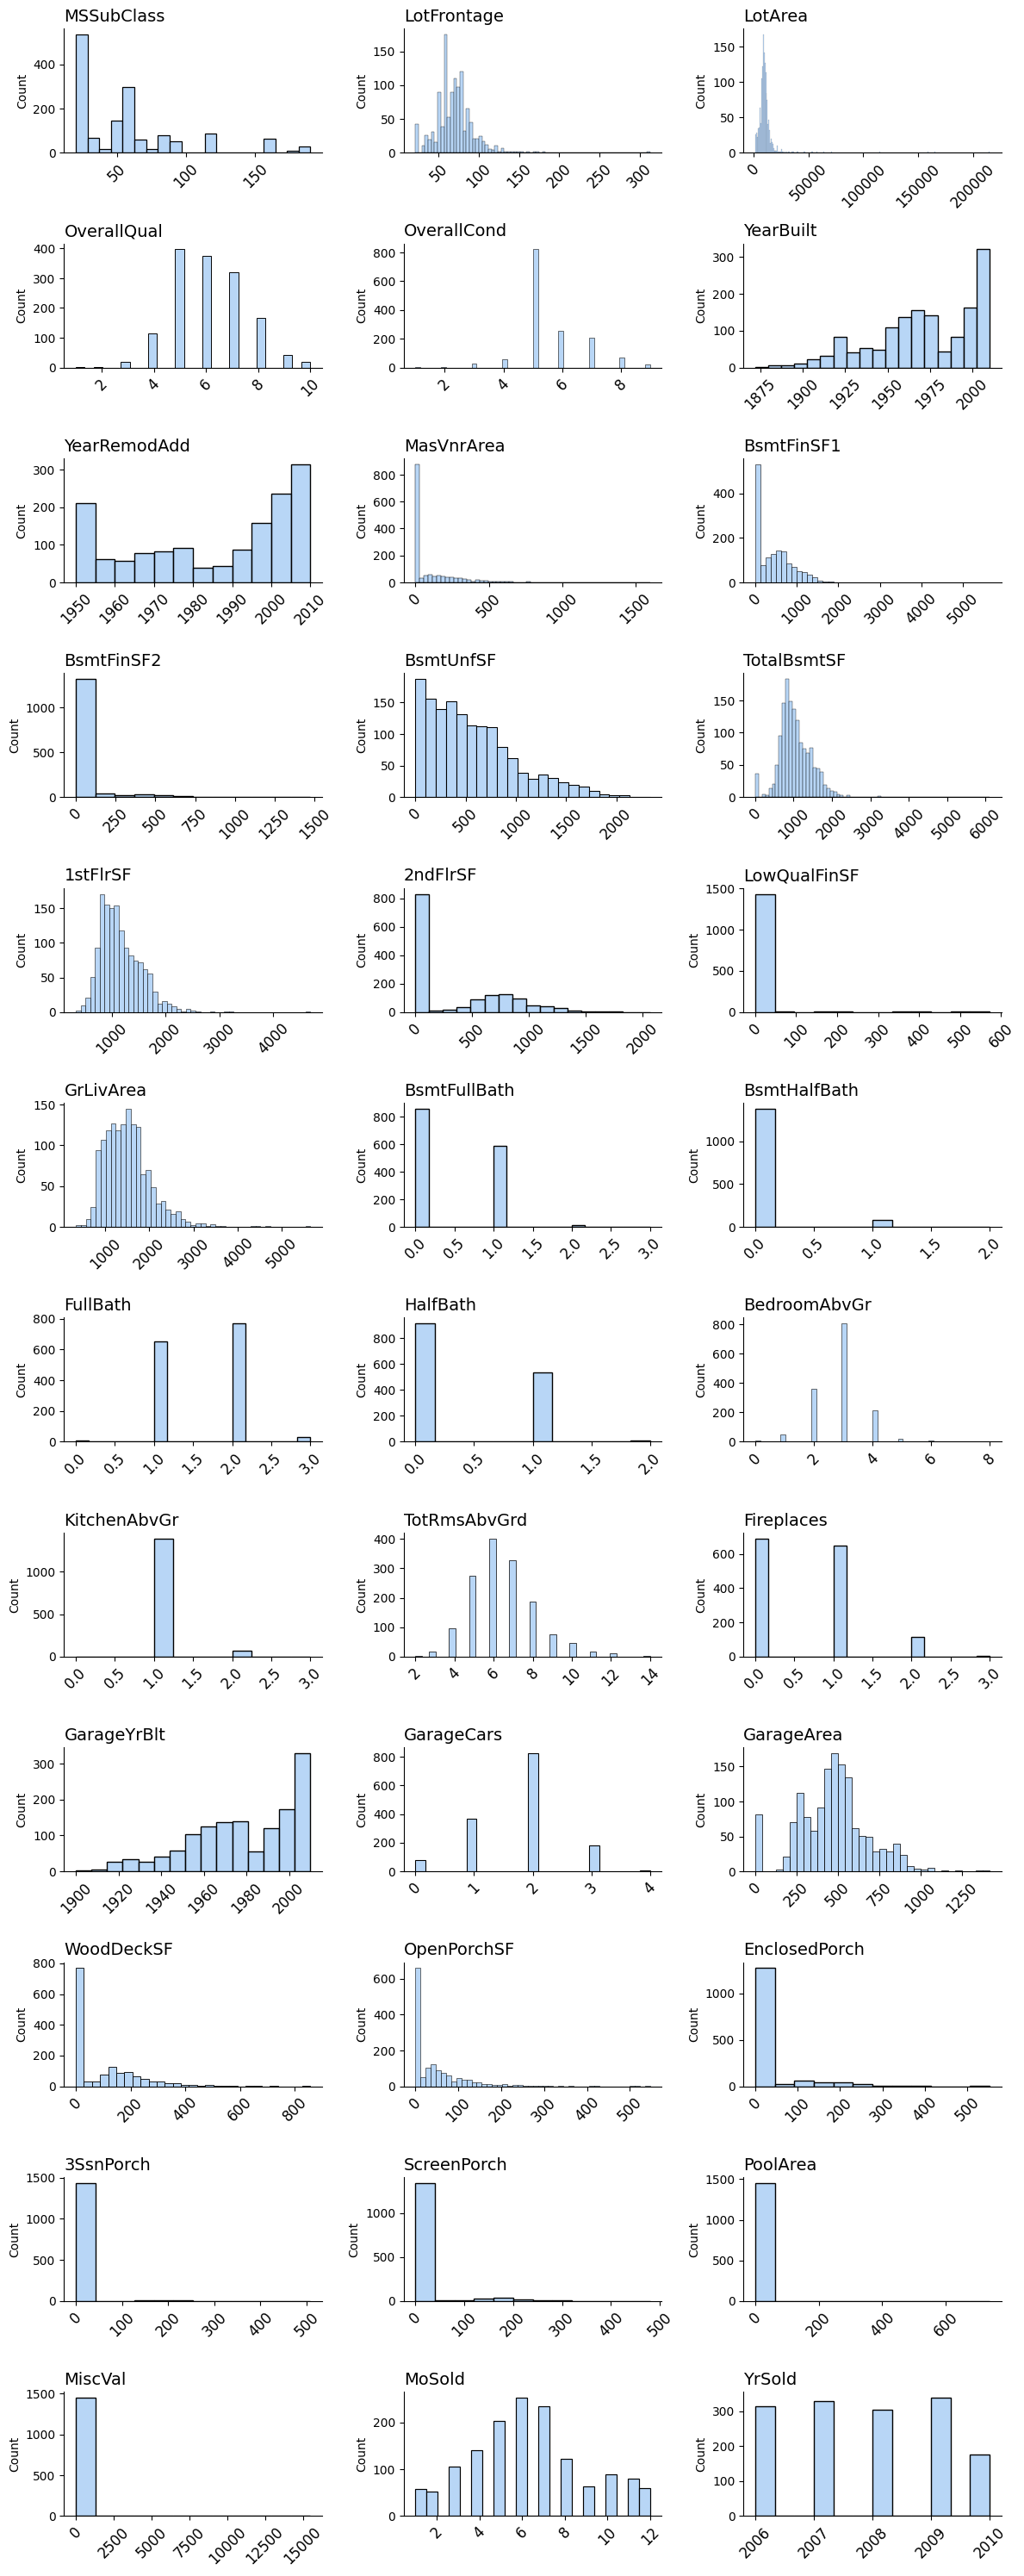

In [351]:
# Plotting numeric features
plt.figure(figsize=(12, 30))

for i, col in enumerate(quantitative):
    ax = plt.subplot(12, 3, i+1)
    ax = sns.histplot(data=train, x=col, color="#A1C9F4")
    ax.set_xlabel("")
    plt.xticks(size=12,rotation=45)
    plt.title(f'{col}', loc='left', fontsize=14)
    sns.despine()
plt.tight_layout()

Algumas variáveis independentes parecem boas candidatas para transformação de log: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea e outras. Embora o ganho na transformação de regressão suavizará algumas irregularidades que podem ser importantes, como uma grande quantidade de casas com 0 2ndFlrSF.

## Verificando distribuição de variáveis categóticas

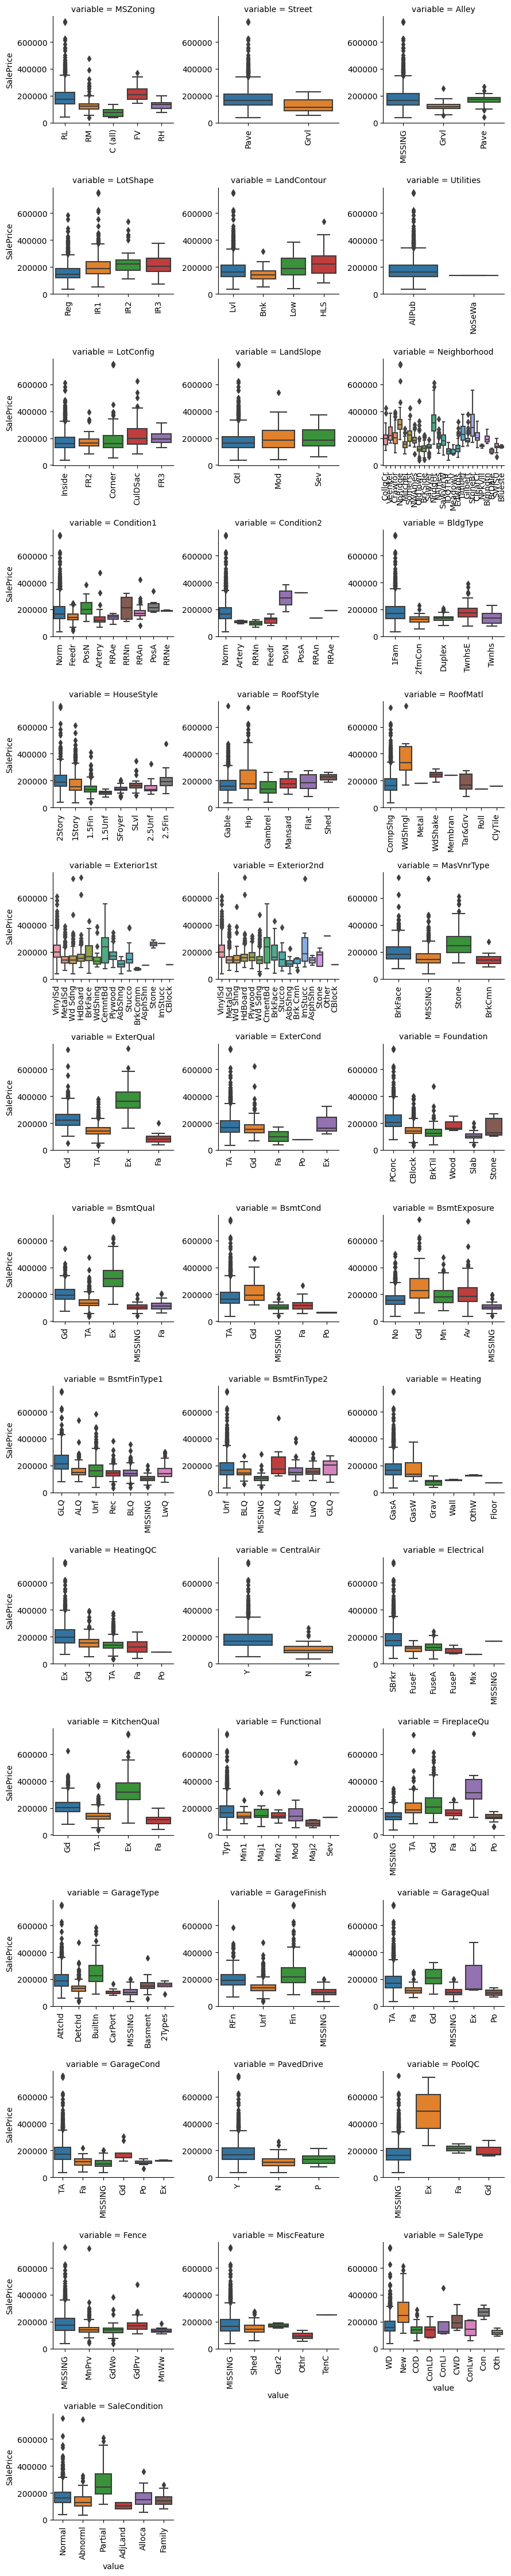

In [352]:
# Plotando variáveis categóricas
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, "value", "SalePrice")

Algumas categorias parecem mais diversas em relação ao SalePrice. A variável Neighborhood tem grande impacto nos preços das casas. O mais caro parece ser Partial SaleCondition. Ter piscina (PoolQC) na propriedade parece melhorar consideravelmente o preço.

## Analisando variáveis e removendo colunas com mais de 50% de nans

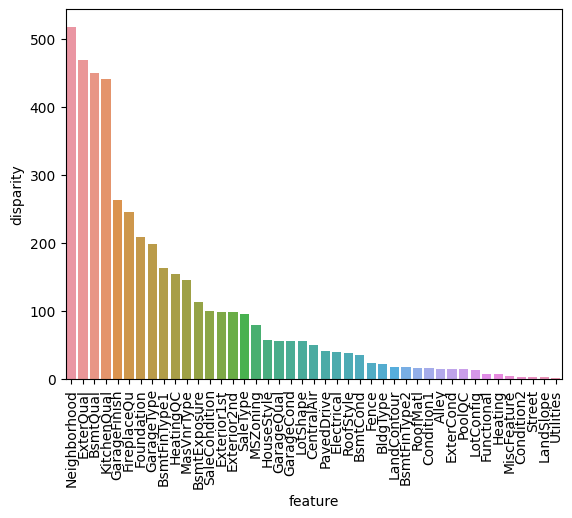

In [353]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [354]:
# Removendo colunas com mais de 50% de nans
cols_to_remove = cols_with_more_50.Features.tolist()

train.drop(columns=cols_to_remove, axis=1, inplace=True)
test.drop(columns=cols_to_remove, axis=1, inplace=True)

## Preparando variáveis

In [355]:
# Separate features and target variable
Xt1 = train.drop(columns=["SalePrice"])
yt1 = train["SalePrice"]

Xt2 = test

# Split the data into training and testing sets
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Define categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Definindo passos para preprocessamento de variáveis quanti e qualitativas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', TargetEncoder(handle_unknown='ignore', handle_missing='value'))])

# Combinando passos dos preprocessadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit_transform o preprocessor
X_processed_t1 = preprocessor.fit_transform(X_train,y_train)
X_processed_t2 = preprocessor.fit_transform(X_test, y_test)

# Jogando o resultado dentro de uma nova variável
x_processed_train = pd.DataFrame(X_processed_t1, columns=X.columns)
x_processed_test = pd.DataFrame(X_processed_t2, columns=X.columns)
x_processed_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.866764,-0.012468,-0.212896,-0.820445,0.372217,-0.455469,-1.346063,-0.597889,1.037269,-0.285504,...,142098.747029,184083.921587,142719.027422,202585.414141,202197.439528,187714.627619,188288.793591,186791.589720,174787.747036,175677.753112
1,0.074110,-0.502357,-0.265245,-0.088934,1.268609,0.718609,0.439214,-0.597889,-0.971996,-0.285504,...,142098.747029,184083.921587,205989.257934,202585.414141,202197.439528,187714.627619,188288.793591,186791.589720,174787.747036,175677.753112
2,-0.631546,-0.146074,-0.177841,-0.820445,1.268609,-1.988293,-1.683818,-0.597889,-0.971996,-0.285504,...,142098.747029,184083.921587,142719.027422,102941.120111,102941.120111,102941.120111,102941.120111,154510.501644,174787.747036,175677.753112
3,-0.161109,-0.457822,-0.324474,-0.820445,1.268609,-1.107734,-1.683818,0.861522,0.267995,-0.285504,...,211442.302128,184083.921587,205989.257934,136585.477273,143901.627083,187714.627619,188288.793591,186791.589720,174787.747036,175677.753112
4,-0.161109,-0.903175,-0.529035,-0.820445,0.372217,-1.531707,-1.683818,-0.597889,-0.496920,-0.285504,...,211442.302128,184083.921587,224858.645902,136585.477273,143901.627083,187714.627619,188288.793591,186791.589720,174787.747036,175677.753112


In [356]:
x_processed_test.isna().sum().sum()

0

### Fit Regressors

In [357]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=SEED)
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', rf)])
rf_pipe.fit(x_processed_train, y_train)

# LGBM Regressor
lgbm = LGBMRegressor(random_state=SEED)
lgbm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgbm)])
lgbm_pipe.fit(x_processed_train, y_train)

# Xgb Regressor
xgb = XGBRegressor(random_state=SEED)
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', xgb)])
xgb_pipe.fit(x_processed_train, y_train)

# Catboost
cat = CatBoostRegressor(verbose=0, random_state=SEED)
cat_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', cat)])
cat_pipe.fit(x_processed_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3159
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 69
[LightGBM] [Info] Start training from score 181441.541952


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQual...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x00000195E2E2EE90>)])

In [358]:
# Previsões
rf_pred = rf_pipe.predict(x_processed_train)
lgbm_pred = lgbm_pipe.predict(x_processed_train)
xgb_pred = xgb_pipe.predict(x_processed_train)
cat_pred = cat_pipe.predict(x_processed_train)

# MSE
rf_score_mse = mean_squared_error(y_train, rf_pred)
lgbm_score_mse = mean_squared_error(y_train, lgbm_pred)
xgb_score_mse = mean_squared_error(y_train, xgb_pred)
cat_score_mse = mean_squared_error(y_train, cat_pred)

# RMSE
rf_score_rmse = np.sqrt(mean_squared_error(y_train, rf_pred))
lgbm_score_rmse = np.sqrt(mean_squared_error(y_train, lgbm_pred))
xgb_score_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred))
cat_score_rmse = np.sqrt(mean_squared_error(y_train, cat_pred))


# Resultados em lista
scores = np.array([['Random Forest', rf_score_mse, rf_score_rmse], ['LGBM', lgbm_score_mse, lgbm_score_rmse], ['XGboost', xgb_score_mse, xgb_score_rmse], ['Catboost', cat_score_mse, cat_score_rmse]])

# Printing dos resultados
results = pd.DataFrame(columns=['Regressors', 'MSE Score', 'RMSE Score'], data=scores).sort_values(by='RMSE Score', ascending=True)
results

,Regressors,MSE Score,RMSE Score
1,LGBM,110691255.26601247,10520.991173174345
0,Random Forest,122032947.87585557,11046.852396762417
3,Catboost,25123546.048635628,5012.339378836556
2,XGboost,937031.0276841334,968.0036299953288


## Tunning o melhor modelo

In [359]:
%%time
# Definir a distribuição de hiperparâmetros
param_grid = {
    'num_leaves': np.arange(20, 150, 50),
    'max_depth': np.arange(5, 15, 3),
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': np.arange(100, 1000, 100),
    'min_child_samples': np.arange(20, 100, 20),
    'subsample': [0.4, 0.6],
    'colsample_bytree': [0.4, 0.6],
    'reg_alpha': np.arange(0, 0.5, 0.1),
    'reg_lambda': np.arange(0, 0.5, 0.1)
}

# Inicializar o modelo CatBoostRegressor
model = LGBMRegressor(random_state=SEED)

# Kfold
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Configurar a busca aleatória
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   n_iter=30, scoring='neg_mean_squared_error', 
                                   cv=cv, random_state=SEED, n_jobs=-1, verbose=1)

# Executar a busca aleatória
random_search.fit(x_processed_train, y_train)

# Obter os melhores hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Treinar o modelo final com os melhores hiperparâmetros
best_model = random_search.best_estimator_
best_model.fit(x_processed_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3156
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 69
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.01, max_depth=5,
              n_estimators=600, num_leaves=20, random_state=42, reg_alpha=0.1,
              reg_lambda=0.4, subsample=0.6)

## Modelo final - Resultados

In [360]:
# Score do nodelo de treino
y_pred = best_model.predict(x_processed_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'Train Mean Squared Error: {rmse}')

# Score do nodelo de validação
y_pred_t = best_model.predict(x_processed_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_t))
print(f'Test Mean Squared Error: {rmse}')

Train Mean Squared Error: 17062.737200009837
Test Mean Squared Error: 29079.28926322562


In [361]:
result = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': y_pred_t})
result['Residuals'] = result['True Labels'] - result['Predicted Labels']
result.head()

,True Labels,Predicted Labels,Residuals
892,154500,143943.247664,10556.752336
1105,325000,350737.049527,-25737.049527
413,115000,121362.908540,-6362.908540
522,159000,153914.806006,5085.193994
1036,315500,313887.326725,1612.673275


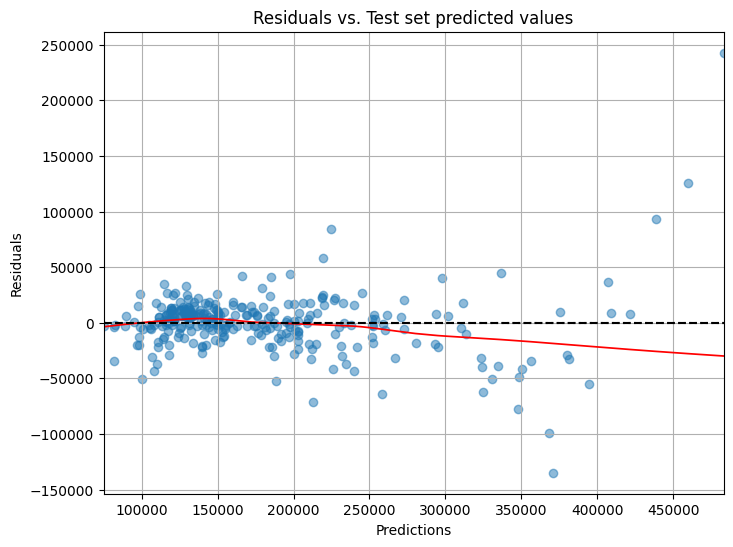

In [362]:
# Plotting residuals against test set predicted values
plt.figure(figsize=(8, 6))

sns.residplot(x=result['Predicted Labels'], y=result['Residuals'], lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1.25})

plt.title('Residuals vs. Test set predicted values')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')  # Add horizontal line at y=0
plt.grid(True)

plt.show()

Por fim temos o modelo concluído utilizando o LightGBM com uma precisão razoável diante do problema proposto. Acima demonstro a precisão do modelo, seus resíduos, o resíduo das previsões e um plot ilustrando os resíduos vs os valores preditos.

O desafio do projeto estava em criar um modelo que gerasse previsões dos valores dos imóveis de modo que a corretora tivesse uma ferramenta confiável que estimasse o preço da casa. Dito isso, o modelo se mostra capaz de informar o custo do imóvel, entretanto, com uma certa margem de erro.